# Self-Driving Car Engineer Nanodegree @Udacity


## Project: **Advanced Lane Lines Finding** 
***
The objective of this project is to identify lane lines on the road, initially on a series of test images and then later on some video streams.

The pipeline I've considered is composed:
* Color selection of the lane lines
* Gray scaling of the images
* Noise reduction with Gaussian blurring
* Edges detection with Canny filter
* Selection of the region of interest
* Lines detection with Hough tranform

Final results of the video processing can be found in the folder [output_videos](output_videos/):
* Project Video: 
  - [project_video.mp4](output_videos/project_video.mp4)
  
* Challenge Video: 
  - [challenge_video.mp4](output_videos/challenge_video.mp4)
  
* Harder Challenge Video: 
  - [harder_challenge_video.mp4](output_videos/harder_challenge_video.mp4)
  
Output of the step by step processing of test images can be found in the folder [output_images](output_images/)


## Import Packages

In [112]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os
from ipywidgets import interact, interact_manual

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [6]:
## Starting with some image utility functions

IMAGE_OUTPUT_PATH = 'output_images/'


def load_images_from_dir(path):
    """ return list of (image, filename) from a specified directory"""
    return [(mpimg.imread(os.path.join(path, file)), file) for file in os.listdir(path)]


def weighted_img(image1, image2, α=0.8, β=1., γ=0.):
    """
    The result image is computed as follows:
    image1 * α + image2 * β + γ
    NOTE: image1 and image2 must be the same shape!
    """
    return cv2.addWeighted(image1, α, image2, β, γ)


def show_images(images_data, in_gray=False, img_per_row=3, figsize=(20, 10)):
    """Display images as is or in grey scale. images_data = [(image, name)...]"""
    # images count
    img_cnt = len(images_data)
    
    # show max 3 images per row. Calculate the rows count
    row_cnt = int((img_cnt-1) / img_per_row) + 1
    
    # display the images
    f, axs =  plt.subplots(row_cnt, img_per_row, figsize=figsize)
    count_images = 0
    for r in range(row_cnt):
        for c in range(img_per_row):
            if count_images < img_cnt:
                count_images += 1
                if row_cnt == 1 and img_per_row == 1:
                     ax = axs
                elif row_cnt == 1:
                    ax = axs[c]
                elif img_per_row == 1:
                    ax = axs[r]
                else:
                    ax = axs[r, c]
                cmap = 'gray' if in_gray else None
                ax.set_title(images_data[img_per_row*r + c][1])
                ax.imshow(images_data[img_per_row*r + c][0], cmap=cmap)

                
def save_images(list_images_data, filename_prefix='', in_gray=False):
    """Save a list of images to disk.
    `list_images_data` is a list of tuple(image, filename)"""
    #
    cmap = 'gray' if in_gray == True else None
    for (image, filename) in list_images_data: 
        plt.imsave(os.path.join(IMAGE_OUTPUT_PATH, filename_prefix+filename), image, cmap=cmap)

        
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    # Code snippet from:
    # https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
    """Apply brightness and/or contrast to an image"""
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


## 1. Camera Calibration

We will use some checkboard images taken by the camera for calibration.
#### a. Let's start looking at some of those chessboard images.

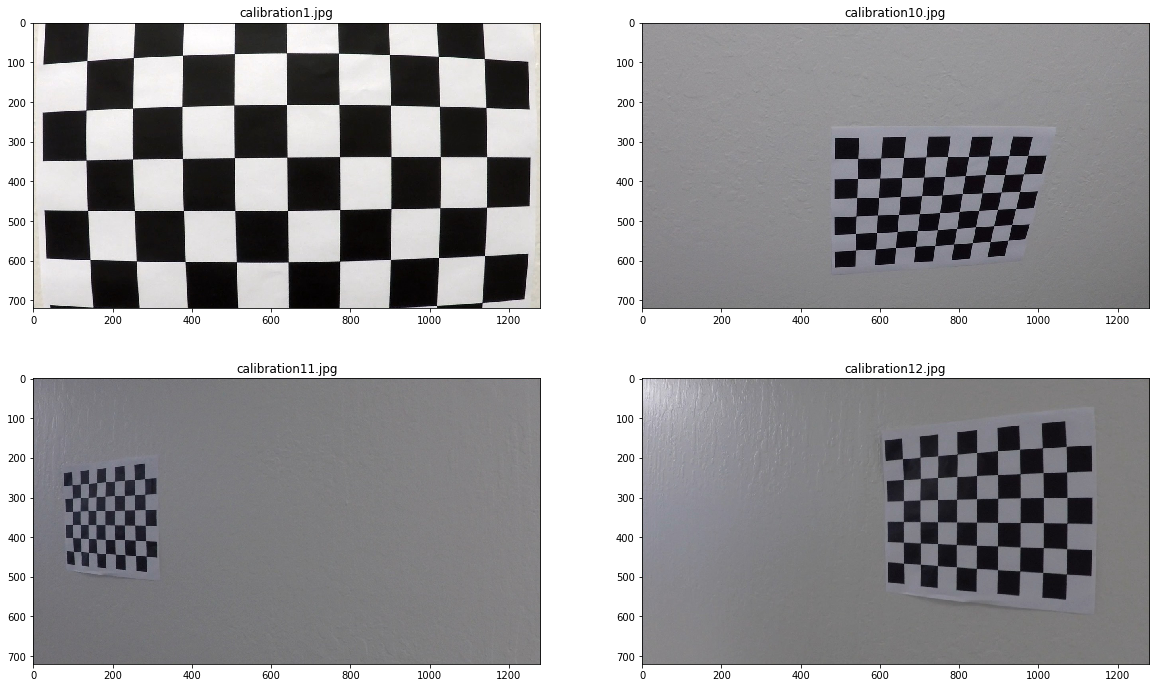

In [7]:
# Make a list of calibration images
cal_images = load_images_from_dir('camera_cal/')
show_images(cal_images[:4], img_per_row=2, figsize=(20, 12))

We will consider for the next steps a 9x6 chessboard.
#### b. Finding the chessboard corners

In [9]:
CHESS_NX = 9
CHESS_XY = 6

# prepare object points
objp = np.zeros((CHESS_XY*CHESS_NX,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESS_NX, 0:CHESS_XY].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = [] # images updated with the drawing of their corners found

# Step through the list and search for chessboard corners
for image, fname in cal_images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CHESS_NX, CHESS_XY), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image = cv2.drawChessboardCorners(image, (CHESS_NX, CHESS_XY), corners, ret)
        img_with_corners.append((image, fname))

Let's see what we get...

Nb images with corners detected 17/20


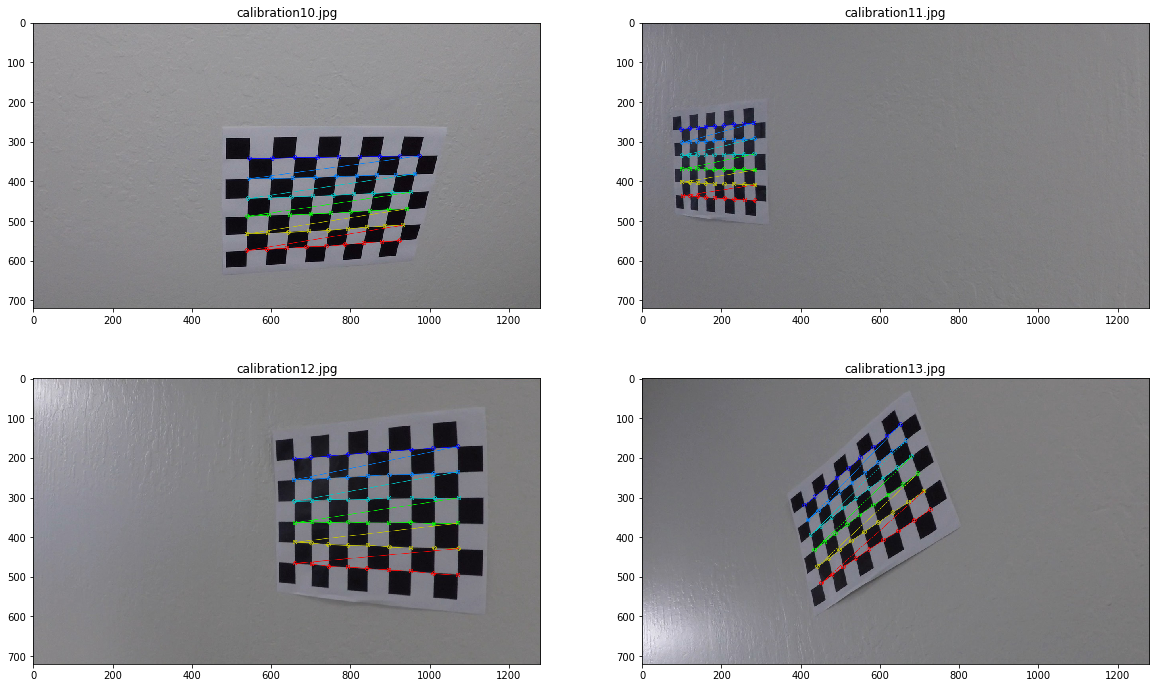

In [10]:
print('Nb images with corners detected {}/{}'.format(len(img_with_corners), len(cal_images)))

# Just display few images with their cornes
nb_image_corners_to_display = np.min([4, len(img_with_corners)])
show_images(img_with_corners[:nb_image_corners_to_display], img_per_row=2, figsize=(20, 12))
save_images(img_with_corners, filename_prefix='with_corners_')

#### c. Calculate the distortion coefficients

In [11]:
# Get thesize of the images
img_size = (cal_images[0][0].shape[1], cal_images[0][0].shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Let's save the interesting distorsion coefficients for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("calibration_dist_pickle.p", "wb"))

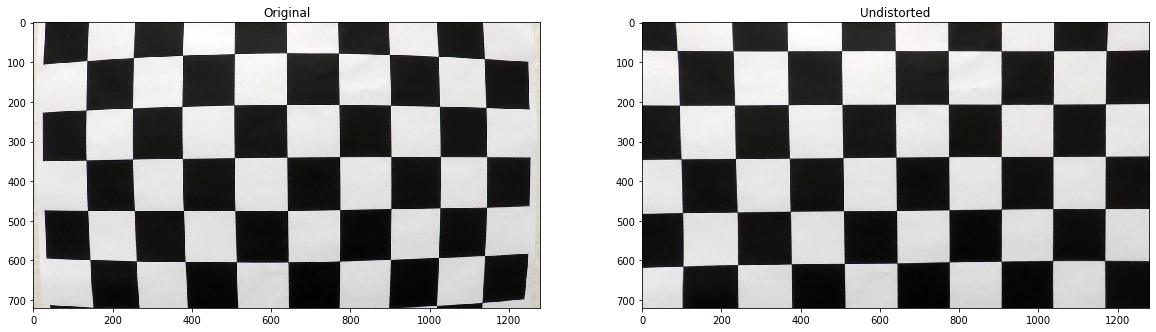

In [12]:
def undistort_image(image, dist, mtx):
    """Utility function to undistort an image, given the distortion coefficients"""
    return cv2.undistort(image, mtx, dist, None, mtx)

# Undistort one of the calibration image to see the effect:
cal_image = cal_images[0][0]
cal_image_undistorted = undistort_image(cal_image, dist, mtx)
show_images([(cal_image, 'Original'), (cal_image_undistorted, 'Undistorted')], img_per_row=2, figsize=(20, 20))
save_images([(cal_image_undistorted, cal_images[0][1])], filename_prefix='undistorted_')


## 2. Load & Undistort test images

In [13]:
# Load the test images
test_images = load_images_from_dir('test_images/')

# Undistort the test images
undistorted_images = [(undistort_image(image, dist, mtx), 'undistorted_'+fname) for (image, fname) in test_images]
save_images(undistorted_images)

# Display images and their undistorted version interactively
@interact(image_index=[(undistorted_images[i][1], i) for i in range(len(undistorted_images))])
def show_undistorted_images(image_index):
    show_images([test_images[image_index], undistorted_images[image_index]], img_per_row=2, figsize=(20, 12))

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

## 3. Thresholded Binary Images
Let's explore how we could get acceptable thresholded binary images

#### A. Exploring different color spaces

In [14]:
# Let's have a look on RGB and HLS channels for each test image

images_index = [(undistorted_images[i][1], i) for i in range(len(undistorted_images))]

# Using an interactive widget to
@interact(image_index=images_index)
def show_rgb_hls(image_index):
    image, fname = undistorted_images[image_index]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # RGB channels
    r_channel = image[:,:,0]
    g_channel = image[:,:,1]
    b_channel = image[:,:,2]
    
    # HLS channels
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Gray')
    ax2.imshow(gray, cmap='gray')
    
    show_images([(r_channel, 'R Channel'), (g_channel, 'G Channel'), (b_channel, 'B Channel')], img_per_row=3, figsize=(20, 10), in_gray=True)
    show_images([(h_channel, 'H Channel'), (l_channel, 'L Channel'), (s_channel, 'S Channel')], img_per_row=3, figsize=(20, 10), in_gray=True)


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

White color is very clear on all RGB channels, as well on the L channel of HSL color space.

Yellow color is stronger on the S channel of HLS, but we also know that H channel hold a consistent value of the color under different lighting. It is also quite Ok on R channel of RGB, a little less on the G channel.

Let's explore some combination of those to see where we can get better result.

In [17]:
# Trying different threshold values to detect white color on RGB & HLS color spaces

@interact(image_index=images_index, rgb_low=(0,255,1), rgb_upper=(0,255,1), l_low=(0,255,1), l_upper=(0,255,1))
def show_white_color_threshold(image_index, rgb_low=190, rgb_upper=255, l_low=190, l_upper=255):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Adjusting image birghtness & constrast, the following threshold value are empirically fixed
    mean_lumi = np.mean(hls[:,:,1])
    
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        
    # threshold ranges
    rgb_low_white = np.array([rgb_low, rgb_low, rgb_low])
    rgb_upper_white = np.array([rgb_upper, rgb_upper, rgb_upper])
    l_low_white = np.array([0, l_low, 0])
    l_upper_white = np.array([255, l_upper, 255])
    
    # create binary images for white color
    rgb_binary = cv2.inRange(image, rgb_low_white, rgb_upper_white) // 255
    l_binary = cv2.inRange(hls, l_low_white, l_upper_white) // 255
    
    color_stack = np.dstack(( np.zeros_like(rgb_binary), rgb_binary, l_binary))*255
    
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Stack')
    ax2.imshow(color_stack)
    ax3.set_title(' - RGB White')
    ax3.imshow(rgb_binary, cmap='gray')
    ax4.set_title(' - HLS White')
    ax4.imshow(l_binary, cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

We noticed also that the road and some part of the surroundings have gray color. 
It might be good idea to reduce as much as possible area with gray color

In [21]:
# Trying different threshold values to detect white gray color on HLS color spaces

@interact(image_index=images_index, l_low=(0,255,1), l_upper=(0,255,1), s_low=(0,255,1), s_upper=(0,255,1))
def show_gray_color_threshold(image_index, l_low=0, l_upper=150, s_low=0, s_upper=20):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        
    # threshold ranges
    l_low_gray = np.array([0, l_low, s_low])
    l_upper_gray = np.array([255, l_upper, s_upper])
    l_binary = cv2.inRange(hls, l_low_gray, l_upper_gray) // 255
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(' - HLS Gray')
    ax2.imshow(l_binary, cmap='gray')

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [22]:
# Trying different threshold values to detect yello color on HLS color space, by combining H & S Channels

@interact(image_index=images_index, h_yello_low=(0,255,1), h_yello_up=(0,255,1), s_yello_low=(0,255,1), s_yello_up=(0,255,1))
def show_yellow_color_threshold(image_index, h_yello_low=10, h_yello_up=40, s_yello_low=100, s_yello_up=255):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
    
    # threshold ranges
    yellow_low = np.array([h_yello_low, 0, s_yello_low])
    yellow_up = np.array([h_yello_up, 255, s_yello_up])
    
    # create binary images for white color
    yellow_binary = cv2.inRange(hls, yellow_low, yellow_up) // 255
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Yellow on HLS')
    ax2.imshow(yellow_binary, cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### B. Exploring some gradiant thresholds based on combination of sobel operators

In [23]:
##########################################################
## Combining gradients...
##########################################################

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'), int(orient=='y'), ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    #Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.abs(sobely), np.abs(sobelx))
    
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary


@interact_manual(image_index=images_index, sobel_kernel=(1, 45, 2), low_thrx=(0, 255, 1), up_thrx=(0, 255, 1), 
          low_thry=(0, 255, 1), up_thry=(0, 255, 1), low_thr_mag=(0, 255, 1), up_thr_mag=(0, 255, 1), 
          low_thr_dir=(0, np.pi/2, 0.1), up_thr_dir=(0, np.pi/2, 0.1))
def gradient_thresh(
    image_index, sobel_kernel=3, low_thrx=40, up_thrx=100, low_thry=40, up_thry=100, 
    low_thr_mag=30, up_thr_mag=100, low_thr_dir=0.7, up_thr_dir=1.3):
    
    image, fname = undistorted_images[image_index]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=(low_thrx, up_thrx))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=(low_thry, up_thry))
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=(low_thr_mag, up_thr_mag))
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, thresh=(low_thr_dir, up_thr_dir))

    #Trying different combinations...
    combined_x_n_y = np.zeros_like(gradx)
    combined_x_n_y[(gradx == 1) & (grady == 1)] = 1
    
    combined_x_o_y = np.zeros_like(gradx)
    combined_x_o_y[(gradx == 1) | (grady == 1)] = 1
    
    combined_x_o_m = np.zeros_like(gradx)
    combined_x_o_m[(gradx == 1) | (mag_binary == 1)] = 1
  
    combined_y_o_m = np.zeros_like(grady)
    combined_y_o_m[(grady == 1) | (mag_binary == 1)] = 1
    
    combined_x_n_d = np.zeros_like(gradx)
    combined_x_n_d[(gradx == 1) & (dir_binary == 1)] = 1
 
    combined_y_n_d = np.zeros_like(grady)
    combined_y_n_d[(grady == 1) & (dir_binary == 1)] = 1

    combined_m_n_d = np.zeros_like(mag_binary)
    combined_m_n_d[(mag_binary == 1) & (dir_binary == 1)] = 1

    combined_x_o_y_o_m = np.zeros_like(gradx)
    combined_x_o_y_o_m[(gradx == 1) | (grady == 1) | (mag_binary == 1)] = 1
    
    combined_x_o_y_n_d = np.zeros_like(gradx)
    combined_x_o_y_n_d[((gradx == 1) | (grady == 1)) & (dir_binary == 1)] = 1
   
    combined_x_o_y_o_m_n_d = np.zeros_like(gradx)
    combined_x_o_y_o_m_n_d[((gradx == 1) | (grady == 1) | (mag_binary == 1)) & (dir_binary == 1)] = 1
    
    combined_gradiants = [
        (gradx, 'X'), (grady, 'Y'), (mag_binary, 'M'), (dir_binary, 'D'),
        (combined_x_n_y, 'X & Y: '+fname), (combined_x_o_y, 'X | Y: '+fname),
        (combined_x_o_m, 'X | M: '+fname), (combined_y_o_m, 'Y | M: '+fname),
        (combined_x_n_d, 'X & D: '+fname), (combined_y_n_d, 'Y & D: '+fname),
        (combined_m_n_d, 'M & D: '+fname), (combined_x_o_y_o_m, 'X | Y | M: '+fname),
        (combined_x_o_y_n_d, 'X | Y & D: '+fname), (combined_x_o_y_o_m_n_d, 'X | Y | M & D: '+fname)
    ]
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Gray')
    ax2.imshow(gray, cmap='gray')
    
    show_images(combined_gradiants, img_per_row=1, figsize=(40, 250), in_gray=True)
    

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### C. Selecting final combination of color & gradient thresholding
After testing multiple combinations we will finally go with a combination of:
* Color thresholding : detecting white and yellow color from RGB & HLS color spaces
* Gradient thresholding : using sobel_x operator

In [27]:
RGB_LOW_WHITE = np.array([200, 200, 200])
RGB_UPPER_WHITE = np.array([255,255,255])
HLS_LOW_WHITE = np.array([0, 200, 0])
HLS_UPPER_WHITE = np.array([255,255,255])
HLS_LOW_YELLOW = np.array([10, 0, 100])
HLS_UPPER_YELLOW = np.array([40, 255, 255])
HLS_LOW_GRAY = np.array([0, 0, 0])
HLS_UPPER_GRAY = np.array([255, 150, 20])
HLS_LOW_BLUE = np.array([90, 0, 0]) #95
HLS_UPPER_BLUE = np.array([130, 255, 255]) #120
HLS_LOW_OTHER = np.array([90, 0, 0]) #95
HLS_UPPER_OTHER = np.array([255, 150, 255]) #120

# Using an interactive widget to
def color_gradient_threshold(image, sobel_kernel=3, thresh=(20, 100), mg_thresh=(30, 100)):
    """Compute combined color & gradient thresholding binary image"""
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    #print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
    
    # create binary image for white & yellow colors
    white_rgb_binary = cv2.inRange(image, RGB_LOW_WHITE, RGB_UPPER_WHITE) // 255
    white_hls_binary = cv2.inRange(hls, HLS_LOW_WHITE, HLS_UPPER_WHITE) // 255
    
    # create binary image for yellow color
    yellow_hls_binary = cv2.inRange(hls, HLS_LOW_YELLOW, HLS_UPPER_YELLOW) // 255
    
    gray_hls_binary = cv2.inRange(hls, HLS_LOW_GRAY, HLS_UPPER_GRAY) // 255
    blue_hls_binary = cv2.inRange(hls, HLS_LOW_BLUE, HLS_UPPER_BLUE) // 255
    other_hls_binary = cv2.inRange(hls, HLS_LOW_OTHER, HLS_UPPER_OTHER) // 255
   
    # Calculate directional X gradient
    sobel_x = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=thresh)
    sobel_y = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=thresh)
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=mg_thresh)
    combined_sobel = np.zeros_like(sobel_x)
    combined_sobel[(sobel_x == 1) | (sobel_y == 1) | (mag_binary == 1)] = 1
    
    # Combined binary threshold
    combined_binary = np.zeros_like(sobel_x)
    combined_binary[((combined_sobel == 1) & (gray_hls_binary == 0) & (other_hls_binary == 0)) |
                    ((white_rgb_binary == 1) & (white_hls_binary == 1)) | (yellow_hls_binary == 1)] = 1
    
    return combined_binary

@interact(image_index=images_index)
def show_color_gradient(image_index):
    image, fname = undistorted_images[image_index]
    
    f, ax =  plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(color_gradient_threshold(image), cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [28]:
# Gradiant & Threshold of the undistorted images
thresholded_images = [(color_gradient_threshold(image), 'thresholded_'+fname) for (image, fname) in undistorted_images]
save_images(thresholded_images)

## 4. Perspective Transform

Let's calculate the perspective transform matrix from a typical image and apply it to our thresholded images

In [30]:
IMG_SIZE = (undistorted_images[0][0].shape[1], undistorted_images[0][0].shape[0])

def compute_perspective_transform_matrix(src_coords, dst_coords):
    """Calculate the perspective transform matric from source & destination coordinates"""
    src = np.float32([src_coords[0], src_coords[1], src_coords[2], src_coords[3]])
    dst = np.float32([dst_coords[0], dst_coords[1], dst_coords[2], dst_coords[3]])
    return cv2.getPerspectiveTransform(src, dst)


def apply_warp_perspective(image, M, img_size=IMG_SIZE, flags=cv2.INTER_LINEAR):
    """Apply warp perspective transform to an image"""
    return cv2.warpPerspective(image, M, img_size, flags=flags)


In [32]:
# Test image to use for calculating the transform matric
perpective_test_image = undistorted_images[0][0]

# Source coordinates
src_coords = [[190, 719], [569, 465], [714, 465], [1126, 719]]

# destination coordinates
dst_coords = [[290, 719], [290, 0], [1026, 0], [1026, 719]]

# Compute transform matrix
M = compute_perspective_transform_matrix(src_coords, dst_coords)

# Compute inverse transform matrix
Minv = compute_perspective_transform_matrix(dst_coords, src_coords)


In [33]:
# Display the warp prespective version of the undistorted and thresholded images

@interact(image_index=images_index)
def show_warped_perspective(image_index):
    u_image, fname = undistorted_images[image_index]
    t_image, fname = thresholded_images[image_index]
    
    warp_u_image = apply_warp_perspective(u_image, M)
    warp_t_image = apply_warp_perspective(t_image, M)
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    
    ax1.imshow(u_image)
    ax1.set_title('Original: '+fname)
    x1 = [src_coords[0][0], src_coords[1][0], src_coords[2][0], src_coords[3][0]]
    y1 = [src_coords[0][1], src_coords[1][1], src_coords[2][1], src_coords[3][1]]
    ax1.plot(x1, y1, 'r--', lw=2)
    
    ax2.imshow(warp_u_image)
    ax1.set_title('Warp: '+fname)
    x2 = [dst_coords[0][0], dst_coords[1][0], dst_coords[2][0], dst_coords[3][0]]
    y2 = [dst_coords[0][1], dst_coords[1][1], dst_coords[2][1], dst_coords[3][1]]
    ax2.plot(x2, y2, 'r--', lw=2)
    
    ax3.imshow(t_image, cmap='gray')
    ax3.set_title('Original Thresholded: '+fname)
    ax3.plot(x1, y1, 'r--', lw=2)
    
    ax4.imshow(warp_t_image, cmap='gray')
    ax4.set_title('Warp Thresholded: '+fname)
    ax4.plot(x2, y2, 'r--', lw=2)

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [34]:
# Generate warp perspective transform images
warp_undistorted_images = [(apply_warp_perspective(image, M), 'warp_'+fname) for (image, fname) in undistorted_images]
save_images(warp_undistorted_images)

warp_thresholded_images = [(apply_warp_perspective(image, M), 'warp_'+fname) for (image, fname) in thresholded_images]
save_images(warp_thresholded_images)

# 5. Finding lane lines

#### A. Looking at the histogram of warp-thresholded images

In [35]:
def get_histogram_peaks(image):
    ypos = image.shape[0]//2
    xpos1 = image.shape[1]//4
    xpos2 = 3*xpos1
    
    histogram = np.sum(image[ypos:,:], axis=0)
    leftx_base = np.argmax(histogram[xpos1-100 : xpos1+100]) + xpos1 - 100
    rightx_base = np.argmax(histogram[xpos2-100 : xpos2+100]) + xpos2 - 100
    
    return leftx_base, rightx_base
    
    
@interact(image_index=images_index)
def show_histogram(image_index):
    image, fname = warp_thresholded_images[image_index]
    
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = image[image.shape[0]//2:,:]

    # Sum across image pixels vertically
    # The highest areas of vertical lines should be larger values
    histogram1 = np.sum(image[2*image.shape[0]//3:, -100+image.shape[1]//4 : 100+image.shape[1]//4], axis=0)
    histogram2 = np.sum(image[2*image.shape[0]//3:, -100+3*image.shape[1]//4 : 150+3*image.shape[1]//4], axis=0)
    histogram1 = image.shape[0] - histogram1
    histogram2 = image.shape[0] - histogram2
    xhisto1 = np.linspace(-100+image.shape[1]//4, 99+image.shape[1]//4, 200)
    xhisto2 = np.linspace(-100+3*image.shape[1]//4, 149+3*image.shape[1]//4, 250)
    lbase, rbase = get_histogram_peaks(image)
    
    
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print(leftx_base, rightx_base)
    print(histogram[leftx_base], histogram[rightx_base])
    
    hist = -1 * np.sum(bottom_half, axis=0) + image.shape[0]

    # Display the image and corresponding histogram
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(image, cmap='gray')
    ax.plot(hist, 'r', lw=4)
    
    ax.plot(xhisto1, histogram1, 'g', lw=4)
    ax.plot(xhisto2, histogram2, 'g', lw=4)
    plt.axvline(x=image.shape[1]/4, c='g', linestyle='--')
    plt.axvline(x=3*image.shape[1]/4, c='g', linestyle='--')
    plt.axvline(x=-100+image.shape[1]/4, c='g', linestyle='-')
    plt.axvline(x=100+image.shape[1]/4, c='g', linestyle='-')
    plt.axvline(x=-100+3*image.shape[1]/4, c='g')
    plt.axvline(x=150+3*image.shape[1]/4, c='g')
    plt.axhline(y=image.shape[0]//2, color='b')
    
    plt.axvline(x=lbase, c='y', linestyle='--', lw=5)
    plt.axvline(x=rbase, c='y', linestyle='--', lw=5)
    plt.axvline(x=leftx_base, c='m', linestyle='--', lw=5)
    plt.axvline(x=rightx_base, c='m', linestyle='--', lw=5)
    
    #fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'hist_'+fname), dpi=fig.dpi)


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### B. Testing line detection with Sliding Windows

In [41]:
def average_distance(X, Y, YP):
    """Return the average distance between 2 curves represented by set of points (X, Y) and (X, YP).
        Note that this assumes both curves are equidistants.
        The formula used is derived from 'Parellel curves parametric formula` from https://en.wikipedia.org/wiki/Parallel_curve.'
    """
    newX = []
    newY = []
    dx = X[1] - X[0]
    DYDX = np.gradient(Y, dx)
    
    D = (Y-YP) * np.sqrt(1 + DYDX**2)
        
    return np.mean(D), D


def equidistance_curve(X, Y, d):
    """Compute the coordinates of points on the curve equidistant to the given curve (X, Y).
        d is the distance between both curves, it can be positive or negative.
    """
    newX = []
    newY = []
    dx = X[1] - X[0]
    DXDY = np.gradient(Y, dx)
    for (x, y, yp) in zip(X, Y, DXDY):
        #n = 2 * a * x + b
        m = np.sqrt(1 + yp**2)
        newX.append(x + d*yp/m)
        newY.append(y - d/m)

    return newX, newY


def get_parralel_line(ploty, fitx, lane_width):
    """Get points coordinates of an equidistant curve and return the fitting parameters"""
    other_y, other_x = equidistance_curve(ploty, fitx, lane_width)
    other_fit = np.polyfit(other_y, other_x, 2)
    other_fitx = np.polyval(other_fit, ploty)
    
    return other_fit, other_fitx


def get_window(image_height, window_height, leftx, rightx, margin, indice):
    """Return next search window for the sliding search algorithm"""
    win_y_low = image_height - (indice+1)*window_height
    win_y_high = image_height - indice*window_height
    win_xleft_low = leftx - margin
    win_xleft_high = leftx + margin
    win_xright_low = rightx - margin
    win_xright_high = rightx + margin
    
    return win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high


def get_window_center(default_good_inds, nonzerox, nonzeroy, win_y_low, win_y_high, 
                      win_x_low, win_x_high, minpix=25, is_left=True, nsegments=4):
    """Compute the center of the next search window.
        If the current window has a minimum number of nonzero pixels, then it is splitted into nsegments sub-windows.
        We check the sub-window in a certain order to see if one of them has the minimum nonzero pixels 
        if so, the mean pixel of that sub-window is considered as center for the next windows.
    """
    dx = (win_x_high - win_x_low)//nsegments
    if is_left:
        for i in range(1, nsegments):
            #if direction < -2
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_high - i*dx) &  (nonzerox < win_x_high)).nonzero()[0]
            if len(good_inds) > minpix:
                return np.int(np.mean(nonzerox[good_inds])), good_inds
    
    if not is_left:
        for i in range(1, nsegments):
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) &  (nonzerox < win_x_low + i*dx)).nonzero()[0]
            if len(good_inds) > minpix:
                return np.int(np.mean(nonzerox[good_inds])), good_inds
        
    return np.int(np.mean(nonzerox[default_good_inds])), default_good_inds


In [49]:

def find_lane_sliding_windows(binary_warped, nwindows=9, margin=100, minpix=25):
    """Find lane lines using sliding windows."""
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftx_base, rightx_base = get_histogram_peaks(binary_warped)

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_found = 0
    right_found = 0
    
    left_missed = 0
    right_missed = 0
    max_missed = 3
    min_dev_pixel = 2000
    leftx_prev = leftx_current
    rightx_prev = rightx_current
    img_width = binary_warped.shape[1]
    
    # Step through the windows one by one
    for window in range(nwindows):
        leftx_prev = leftx_current
        rightx_prev = rightx_current
        
        win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
            get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window)
        
        if win_xleft_low < 0 or win_xleft_high > img_width:
            left_missed = max_missed
        if win_xright_low < 0 or win_xright_high > img_width:
            right_missed = max_missed
        
        if left_missed < max_missed:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
            
            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            # If we found > minpix pixels, recenter next window 
            # (`right` or `leftx_current`) on their mean position
            if len(good_left_inds) > minpix:
                leftx_current, good_left_inds = \
                    get_window_center(good_left_inds, nonzerox, nonzeroy, win_y_low, win_y_high, win_xleft_low, 
                                      win_xleft_high, min_dev_pixel, True)
                left_found += 1
                left_missed = 0
            elif window > 0:
                win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window-1)

                good_left_inds_tmp = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low-margin//2) &  (nonzerox < win_xleft_high+margin//2)).nonzero()[0]

                if len(good_left_inds_tmp) > minpix:
                    # step back
                    cv2.rectangle(out_img, (win_xleft_low-margin//2, win_y_low), (win_xleft_high+margin//2, win_y_high), (255, 255, 0), 2)
                    
                    leftx_current, good_left_inds_tmp = \
                        get_window_center(good_left_inds_tmp, nonzerox, nonzeroy, win_y_low, win_y_high, win_xleft_low, 
                                          win_xleft_high, min_dev_pixel, True)
                    left_lane_inds.append(good_left_inds_tmp)
                    left_missed = 0

                    # redo current step
                    win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                        get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window)

                    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 255), 2)

                    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

                    if len(good_left_inds) > minpix:
                        leftx_current, good_left_inds = \
                            get_window_center(good_left_inds, nonzerox, nonzeroy, win_y_low, win_y_high, win_xleft_low, 
                                              win_xleft_high, min_dev_pixel, True)
                        left_found += 1
                        left_missed = 0
                    else:
                        if len(good_left_inds) ==0: left_missed += 1
                else:
                    if len(good_left_inds) ==0: left_missed += 1
            
        if right_missed < max_missed:
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            if len(good_right_inds) > minpix:
                rightx_current, good_right_inds = \
                    get_window_center(good_right_inds, nonzerox, nonzeroy, win_y_low, win_y_high, win_xright_low, 
                                      win_xright_high, min_dev_pixel, False)
                right_found += 1
                right_missed = 0
            elif window > 0:
                win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window-1)

                good_right_inds_tmp = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low-margin//2) &  (nonzerox < win_xright_high+margin//2)).nonzero()[0]

                if len(good_right_inds_tmp) > minpix:
                    # step back
                    cv2.rectangle(out_img, (win_xright_low-margin//2, win_y_low), (win_xright_high+margin//2, win_y_high), (255, 255, 0), 2)
                    rightx_current, good_right_inds_tmp = \
                        get_window_center(good_right_inds_tmp, nonzerox, nonzeroy, win_y_low, win_y_high, win_xright_low, 
                                          win_xright_high, min_dev_pixel, False)
                    right_lane_inds.append(good_right_inds_tmp)
                    right_missed = 0

                    # redo current step
                    win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                        get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window)

                    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 255), 2)

                    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

                    if len(good_right_inds) > minpix:
                        rightx_current, good_right_inds = \
                            get_window_center(good_right_inds, nonzerox, nonzeroy, win_y_low, win_y_high, win_xright_low, 
                                              win_xright_high, min_dev_pixel, False)
                        right_found += 1
                        right_missed = 0
                    else:
                        if len(good_right_inds) == 0: right_missed += 1
                else:
                    if len(good_right_inds) == 0: right_missed += 1
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if left_missed >= max_missed and right_missed >= max_missed:
            break;
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    lane_width = rightx_base-leftx_base
    return leftx, lefty, rightx, righty, out_img, left_found, right_found, lane_width


In [51]:

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    """Fit detected left and right lanes prixels to polynomial functions"""
    
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Compute both polynomials using ploty, left_fit and right_fit
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty


def fit_poly_gen(img_shape, X, Y, lane_width):
    """Fit detected pixels to a polynomial function and generate equidistant lane parameters."""
    
    # Fit a second order polynomial to each with np.polyfit()
    fit = np.polyfit(Y, X, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Compute both polynomials using ploty, left_fit and right_fit
    fitx = np.polyval(fit, ploty)
    
    other_y, other_x = equidistance_curve(ploty, fitx, lane_width)
    other_fit = np.polyfit(other_y, other_x, 2)
    other_fitx = np.polyval(other_fit, ploty)
    
    return fit, other_fit, fitx, other_fitx, ploty


def search_with_sliding_windows(binary_warped, best_lane_width=None):
    """Search lane lines using sliding window and fit detected pixel with polynomial curve."""
    
    # Find our lane pixels first
    nwindows = 9
    
    leftx, lefty, rightx, righty, out_img, left_found, right_found, lane_width = find_lane_sliding_windows(binary_warped, nwindows)
    
    fit_left_line = True if (left_found < nwindows//2 and 2*left_found < right_found) else False
    fit_right_line = True if (right_found < nwindows//2 and 2*right_found < left_found) else False

    if best_lane_width == None:
            best_lane_width = lane_width
    else:
        best_lane_width = (best_lane_width+lane_width)/2
    
    right_fit, left_fit, right_fitx, left_fitx, ploty = (None, None, None, None, None)
    # Fit a second order polynomial to each using `np.polyfit`
    if fit_right_line:
        if left_found > nwindows//2 and len(leftx) > 0:
            left_fit, right_fit, left_fitx, right_fitx, ploty = \
                fit_poly_gen(binary_warped.shape, leftx, lefty, -best_lane_width)
    elif fit_left_line:
        if right_found > nwindows//2 and len(rightx) > 0:
            right_fit, left_fit, right_fitx, left_fitx, ploty = \
                fit_poly_gen(binary_warped.shape, rightx, righty, best_lane_width)
    else:
        if (right_found > nwindows//2 or left_found > nwindows//2) and len(leftx) > 0 and len(rightx) > 0:
            left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width


@interact(image_index=images_index)
def show_sliding_windows(image_index):
    """Visualization of the sliding windows search."""
    
    warp_image,fname = warp_thresholded_images[image_index]
    sliding_image, left_fitx, right_fitx, ploty, _, _, x  = search_with_sliding_windows(warp_image)
    
    if left_fitx is not None and right_fitx is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.imshow(warp_image, cmap='gray')
        ax1.set_title(fname)

        ax2.imshow(sliding_image)
        ax2.set_title('Sliding windows: '+fname)
        
        # Plots the left and right polynomials on the lane lines
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')

        #fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'slidingw_'+fname), dpi=fig.dpi)
    

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### C. Testing line detection with around poly search (after lines on previous images have been detected using sliding window)

In [52]:
def search_around_poly(binary_warped, left_fit, right_fit, best_lane_width=None, margin=100):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #print(leftx, lefty, rightx, righty)
    fit_left_line = len(leftx) == 0
    fit_right_line = len(rightx) == 0
    new_left_fit, new_right_fit, right_fitx, left_fitx, ploty = (None, None, None, None, None)
    
    if not fit_left_line and not fit_right_line:
        new_left_fit, new_right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    elif fit_right_line:
        if best_lane_width is not None:
            print('Fitting right line in search_around_poly')
            new_left_fit, new_right_fit, left_fitx, right_fitx, ploty = fit_poly2(binary_warped.shape, leftx, lefty, -best_lane_width)
    elif fit_left_line:
        if best_lane_width is not None:
            print('Fitting left line in search_around_poly')
            new_right_fit, new_left_fit, right_fitx, left_fitx, ploty = fit_poly2(binary_warped.shape, rightx, righty, best_lane_width)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    if left_fitx is not None and ploty is not None:
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    
    if right_fitx is not None and ploty is not None:
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty, new_left_fit, new_right_fit


@interact(image1_index=images_index, image2_index=images_index)
def show_sliding_windows_n_search_around_poly(image1_index=5, image2_index=2):
    warp_image1, fname1 = warp_thresholded_images[image1_index]
    sliding_image, left_fitx1, right_fitx1, ploty1, left_fit1, right_fit1, _  = search_with_sliding_windows(warp_image1)
    
    warp_image2, fname2 = warp_thresholded_images[image2_index]
    around_poly_image, left_fitx2, right_fitx2, ploty2, left_fit2, right_fit2  = search_around_poly(warp_image2, left_fit1, right_fit1)
    
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(20, 10))
    ax1.imshow(warp_image1, cmap='gray')
    ax1.set_title(fname1)
    ax2.imshow(sliding_image)
    ax2.set_title('Sliding windows: '+fname1)
    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fitx1, ploty1, color='yellow')
    ax2.plot(right_fitx1, ploty1, color='yellow')
    
    ax3.imshow(warp_image2, cmap='gray')
    ax3.set_title(fname2)
    ax4.imshow(around_poly_image)
    ax4.set_title('Around Poly Search: '+fname2)
    ax4.plot(left_fitx2, ploty2, color='yellow')
    ax4.plot(right_fitx2, ploty2, color='yellow')
    
    fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'aroundPolySearch_'+fname2), dpi=fig.dpi)
    

interactive(children=(Dropdown(description='image1_index', index=5, options=(('undistorted_00147_image.jpg', 0…

#### D. Recast detected lane into undistorted image

In [57]:
def recast_to_original(undist_image, warp_image, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, IMG_SIZE) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    return result


@interact(image_index=images_index)
def interact_recast_to_original(image_index=5):
    warp_image, fname = warp_thresholded_images[image_index]
    undist_image, undist_fname = undistorted_images[image_index]
    sliding_image, left_fitx, right_fitx, ploty, left_fit, right_fit, _ = search_with_sliding_windows(warp_image)
    final_image = recast_to_original(undist_image, warp_image, left_fitx, right_fitx, ploty)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(sliding_image)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    
    ax2.imshow(final_image)

interactive(children=(Dropdown(description='image_index', index=5, options=(('undistorted_00147_image.jpg', 0)…

## Testing the Pipeline on Videos

#### A. Utility class to hold some lines tracking parameters

In [126]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, iterations=5, car_pos=640, max_delta_lane_width=0.5, curvature_infinite=10000, 
                 xm_per_pix=3.7/700, ym_per_pix=30/720):
        # max number of iterations to keep
        self.n = iterations
        # was the line detected in the last iteration?
        self.detected = False #***
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the last n fits of the line
        self.recent_radius_of_curvatures = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #radius of curvature averaged over the last n iterations
        self.best_radius_of_curvature = None
        #x-position of the car in the image
        self.car_pos = car_pos
        #distance in meters of vehicle center from the line
        self.line_base_pos = None #***
        ###difference in fit coefficients between last and new fits
        ##self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #average lane width
        self.lane_widths = []
        self.best_lane_width = None
        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix
        # curvature is > to this value, we consider we have a straight line
        self.curvature_infinite = curvature_infinite
        self.max_delta_lane_width = max_delta_lane_width #0.5 #m #***
    
    
    def _curvature_real(self, fit, y_eval):
        '''
        Calculates the curvature of polynomial functions in meters.
        Define y-value where we want radius of curvature
        '''
        # Define y-value where we want radius of curvature
        curverad = np.power(1 + (2*fit[0]*y_eval*self.ym_per_pix + fit[1])**2, 1.5)/(2*np.abs(fit[0]))
        return curverad

    
    def _car_pos_from_line(self):
        return (self.car_pos - self.bestx[-1]) * self.xm_per_pix

    
    def sanity_check(self, fit, fitx, ploty):
        self.detected = False
        
        if fit is None or fitx is None or ploty is None:
            return False
        
        if self.allx is not None:
            lane_width_at_car_pos = np.abs(fitx[-1] - self.allx[-1]) * self.xm_per_pix
            if lane_width_at_car_pos > self.max_delta_lane_width:
                return False
        
        self.detected = True
        return True

        
    def update(self, fit, fitx, ploty, lane_width, skip_check=False):
        if fit is None or fitx is None or ploty is None:
            return
        rad_curv = self._curvature_real(fit, np.max(ploty))
        if lane_width is not None:
            self.lane_widths.append(lane_width)
            self.best_lane_width = np.mean(self.lane_widths)
        
        self.recent_xfitted.append(fitx)
        if len(self.recent_xfitted) > self.n:
            self.recent_xfitted = self.recent_xfitted[-self.n:]
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        
        self.allx = fitx
        self.ally = ploty
        
        self.recent_fits.append(fit)
        if len(self.recent_fits) > self.n:
            self.recent_fits = self.recent_fits[-self.n:]
        self.best_fit = np.mean(self.recent_fits, axis=0)
        self.current_fit = fit
        
        self.line_base_pos = self._car_pos_from_line()
        
        self.recent_radius_of_curvatures.append(rad_curv)
        if len(self.recent_radius_of_curvatures) > self.n:
            self.recent_radius_of_curvatures = self.recent_radius_of_curvatures[-self.n:]
        self.best_radius_of_curvature = np.mean(self.recent_radius_of_curvatures)
        self.radius_of_curvature = rad_curv
        
        return True
    
    
LEFT_LINES = None
RIGHT_LINES = None

#### B. Processing an image

In [127]:
MAX_LANE_DIFF = 150 #150

def lane_width_ok(lane_width, best_lane_width):
    DIFFS.append(lane_width - best_lane_width)
    return np.abs(lane_width - best_lane_width) <= MAX_LANE_DIFF

    
def lane_widths_ok(lane_widths, best_lane_width):
    size = len(lane_widths)
    if size < 4:
        return False
    
    return (
        lane_width_ok(lane_widths[size//2], best_lane_width) and 
        lane_width_ok(lane_widths[-1], best_lane_width))


def process_image(image):
    """Return final output. The result is a color image (3 channel)"""
    
    # 1. Undistorted image
    undistorted = undistort_image(image, dist, mtx)
    
    # 2. Color & Gradient Thresholding
    thresholded = color_gradient_threshold(undistorted)

    # 3. Warp thresholded image
    warped = apply_warp_perspective(thresholded, M)
    
    # 4. Find lines
    lane_width = None
    left_curverad = None
    right_curverad = None
    visu_image = warped
    status_left = False
    status_right = False
    
    if LEFT_LINES.detected or RIGHT_LINES.detected:
        visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit  = search_around_poly(warped, LEFT_LINES.best_fit, RIGHT_LINES.best_fit)
        
    else:
        visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width  = search_with_sliding_windows(warped, LEFT_LINES.best_lane_width)
    
    if left_fit is not None and right_fit is not None:
        avg_lane_width, lane_widths = average_distance(ploty, right_fitx, left_fitx)
        if (LEFT_LINES.best_lane_width is not None and
            (not lane_width_ok(avg_lane_width,LEFT_LINES.best_lane_width) or
             not lane_widths_ok(lane_widths,LEFT_LINES.best_lane_width))):
            status_left = False
            status_right = False
        else:
            status_left = LEFT_LINES.sanity_check(left_fit, left_fitx, ploty)
            status_right = RIGHT_LINES.sanity_check(right_fit, right_fitx, ploty)

        if not status_left or not status_right:
            visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width  = search_with_sliding_windows(warped, LEFT_LINES.best_lane_width)
            if left_fit is not None and right_fit is not None:
                avg_lane_width, lane_widths = average_distance(ploty, right_fitx, left_fitx)
                if (LEFT_LINES.best_lane_width is not None and
                    (not lane_width_ok(avg_lane_width,LEFT_LINES.best_lane_width) or
                     not lane_widths_ok(lane_widths,LEFT_LINES.best_lane_width))):
                    status_left = False
                    status_right = False
                else:
                    status_left = LEFT_LINES.sanity_check(left_fit, left_fitx, ploty)
                    status_right = RIGHT_LINES.sanity_check(right_fit, right_fitx, ploty)

                if status_right and (not status_left) and (LEFT_LINES.best_lane_width is not None):
                    left_fit, left_fitx = get_parralel_line(ploty, right_fitx, LEFT_LINES.best_lane_width)
                    status_left = LEFT_LINES.sanity_check(left_fit, left_fitx, ploty)
                    lane_width = None
                    
                elif status_left and (not status_right) and (RIGHT_LINES.best_lane_width is not None):
                    right_fit, right_fitx = get_parralel_line(ploty, left_fitx, -RIGHT_LINES.best_lane_width)
                    status_right = RIGHT_LINES.sanity_check(right_fit, right_fitx, ploty)
                    lane_width = None
    
    # Update the LEFT and RIGHT Lines 
    if status_left:
        LEFT_LINES.update(left_fit, left_fitx, ploty, lane_width)
    
    if status_right:
        RIGHT_LINES.update(right_fit, right_fitx, ploty, lane_width)
    
    result = recast_to_original(undistorted, warped, LEFT_LINES.bestx, RIGHT_LINES.bestx, LEFT_LINES.ally)
   
    color_thres = np.dstack((thresholded, thresholded, thresholded))*255
    color_warp = np.dstack((warped, warped, warped))*255
    debug_images = [(undistorted, 'Undistorted'), (color_thres, 'Thresholded'), (color_warp, 'Warped'), (visu_image, 'Line finding')]
    hsize = result.shape[0]//4
    wsize = result.shape[1]//4
    debug_images = [(cv2.resize(img, (wsize, hsize), interpolation = cv2.INTER_AREA), text) for (img, text) in debug_images]
    for i in range(len(debug_images)):
        result[:hsize, i*wsize:(i+1)*wsize] = debug_images[i][0]
        cv2.putText(result, debug_images[i][1], (i*wsize+5, 20), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, 
                thickness=5, color=(0, 0, 0))
        cv2.putText(result, debug_images[i][1], (i*wsize+5, 20), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, 
                    thickness=2, color=(0, 255, 0))

    # Compute position of the car vs center of the lane and average radius of curvature
    car_position = (LEFT_LINES.line_base_pos + RIGHT_LINES.line_base_pos) / 2
    curve_rad = (LEFT_LINES.best_radius_of_curvature + RIGHT_LINES.best_radius_of_curvature) / 2
    
    curve_rad = 'Radius of curvature: {:6.2f}m'.format(curve_rad) if curve_rad < 10000 else 'Radius of curvature: -'
    cv2.putText(result, curve_rad, (25, hsize+35), cv2.FONT_HERSHEY_PLAIN, 2,(0,0,0),5,cv2.LINE_AA)
    cv2.putText(result, curve_rad, (20, hsize+30), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,"Car's position: {:4.2f}m".format(car_position), (853, hsize+33), 
                    cv2.FONT_HERSHEY_PLAIN, 2,(0,0,0),5,cv2.LINE_AA)
    cv2.putText(result,"Car's position: {:4.2f}m".format(car_position), (850, hsize+30), 
                    cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
    return result


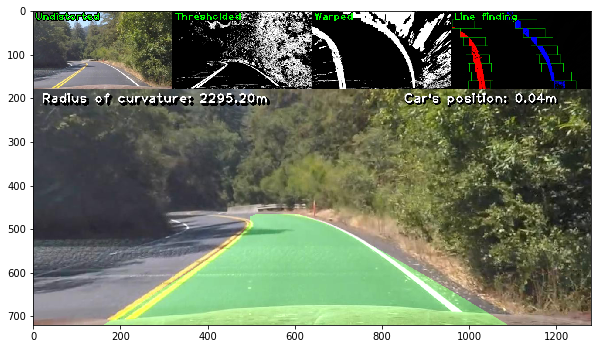

In [128]:
LEFT_LINES = Line()
RIGHT_LINES = Line()

timage = test_images[5][0]
result = process_image(timage)
_, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(result)

#### C. Video Processing

In [129]:
def process_video(input_file, output_file, subclip=None):
    """Run the full Pipeline on the input video file and save the result on output file"""
    if subclip is not None:
        subclip_start, subclip_end = subclip
        clip1 = VideoFileClip(input_file).subclip(subclip_start, subclip_end)
    else:
        clip1 = VideoFileClip(input_file)
        
    processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time processed_clip.write_videofile(output_file, audio=False)
    clip1.reader.close()
    clip1.audio.reader.close_proc()

    
def show_video(video):
    return HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video))

#### D. The Project Video Processing

In [130]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
project_video = 'output_videos/project_video.mp4'
process_video('project_video.mp4', project_video)

show_video(project_video)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [04:20<00:00,  5.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 4min 21s


In [131]:
#### E. The Challenge Video Processing

In [125]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
challenge_output = 'output_videos/challenge_video.mp4'
process_video('challenge_video.mp4', challenge_output)

show_video(challenge_output)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [01:39<00:00,  5.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 40s


#### F. The Harder Challenge Video Processing

In [132]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
harder_challenge_output = 'output_videos/harder_challenge_video.mp4'
process_video('harder_challenge_video.mp4', harder_challenge_output)

show_video(harder_challenge_output)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [05:26<00:00,  4.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 5min 27s
